<a href="https://colab.research.google.com/github/LevTG/Xtest/blob/main/Xtest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tifffile
!pip install celluloid
!apt install ffmpeg
!apt install imagemagick

In [3]:
import re

import numpy as np
import tifffile
import matplotlib.pyplot as plt
 
%matplotlib inline

# Чтение файлов

In [4]:
filename = '/content/drive/MyDrive/Colab Notebooks/Xtest/Xtest.tiff'
frames = tifffile.imread(filename)

In [5]:
frames.shape

(670, 160, 170)

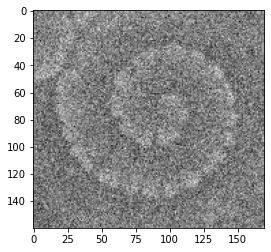

In [6]:
plt.imshow(frames[0], cmap='gray')

Вычитание среднего

In [7]:
mean_frame = np.mean(frames, axis=0)
mean_frames = np.subtract(frames, mean_frame)
mean_frames.shape

(670, 160, 170)

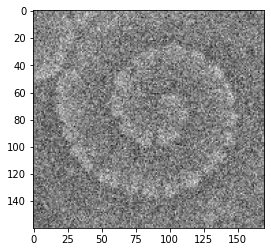

In [8]:
plt.imshow(mean_frames[0], cmap='gray')

Кадр -> Вектор

In [9]:
reshaped_frames = mean_frames.reshape((mean_frames.shape[0], -1))
reshaped_frames.shape

(670, 27200)

Сингулярное разложение

In [10]:
time_comp, s, spatial_comp = np.linalg.svd(reshaped_frames, full_matrices=False)

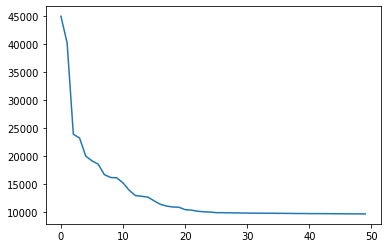

In [11]:
plt.plot(s[:50])

In [36]:
s[:20]

array([45038.81017409, 40243.57758101, 23878.19105583, 23215.779925  ,
       19964.85998491, 19110.30561086, 18520.21203315, 16632.43432312,
       16135.8856198 , 16062.63300682, 15162.21729318, 13835.00190281,
       12890.05709626, 12761.19754845, 12609.91227532, 11941.13500232,
       11329.95211784, 11007.27066332, 10840.71877772, 10796.44546478])

### Временные компоненты

In [12]:
time_comp.shape

(670, 670)

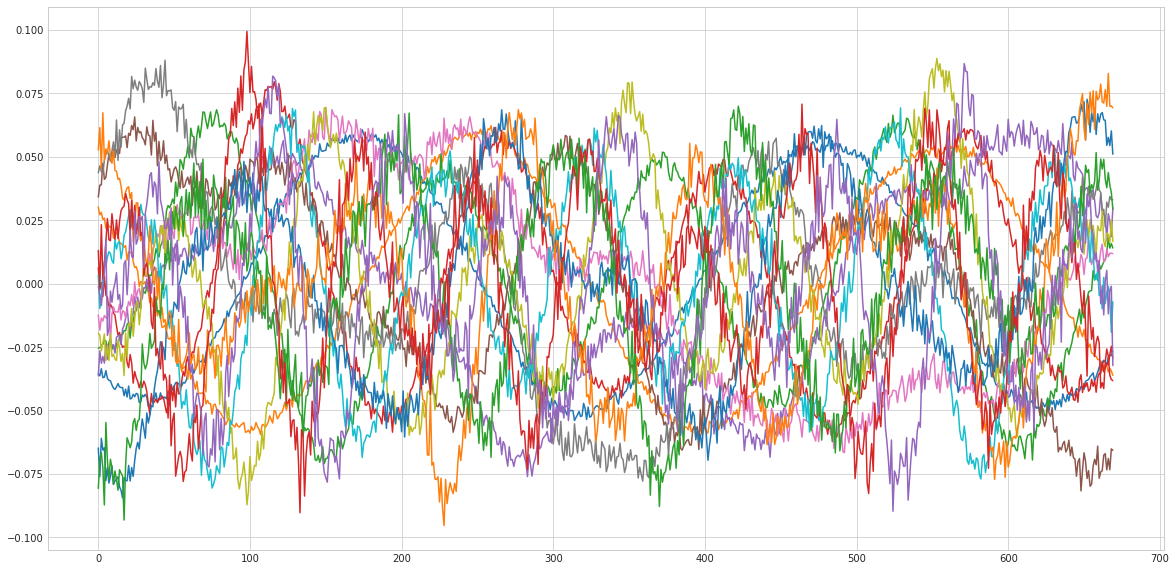

In [13]:
fig = plt.figure(figsize=(20, 10))
with plt.style.context('seaborn-whitegrid'):
    plt.plot(time_comp[:, :15])
plt.show()

Все графики периодичны,

Что логично

Ведь реакция циклична

In [14]:
n, m = 4, 4 

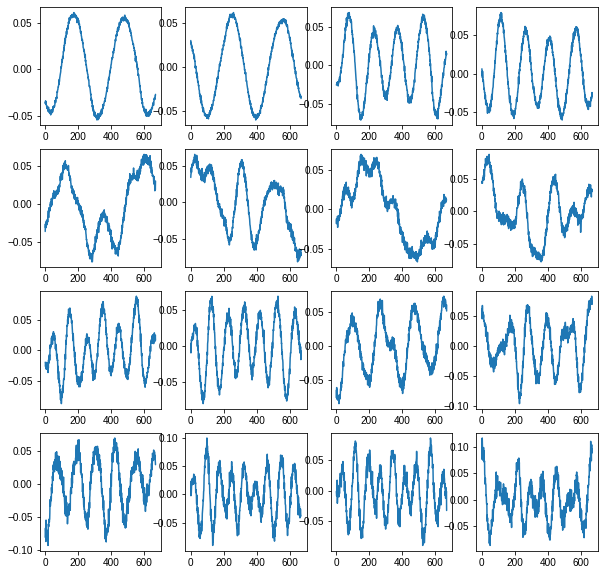

In [15]:
fig, axs = plt.subplots(n, m, figsize=(10,10))
with plt.style.context('seaborn-whitegrid'):
    for i, ax in enumerate(axs):
        for j, axx in enumerate(ax):
            axx.plot(time_comp[:, (i*n+j)])
    plt.show()

### Пространственные компоненты

In [16]:
spatial_comp.shape

(670, 27200)

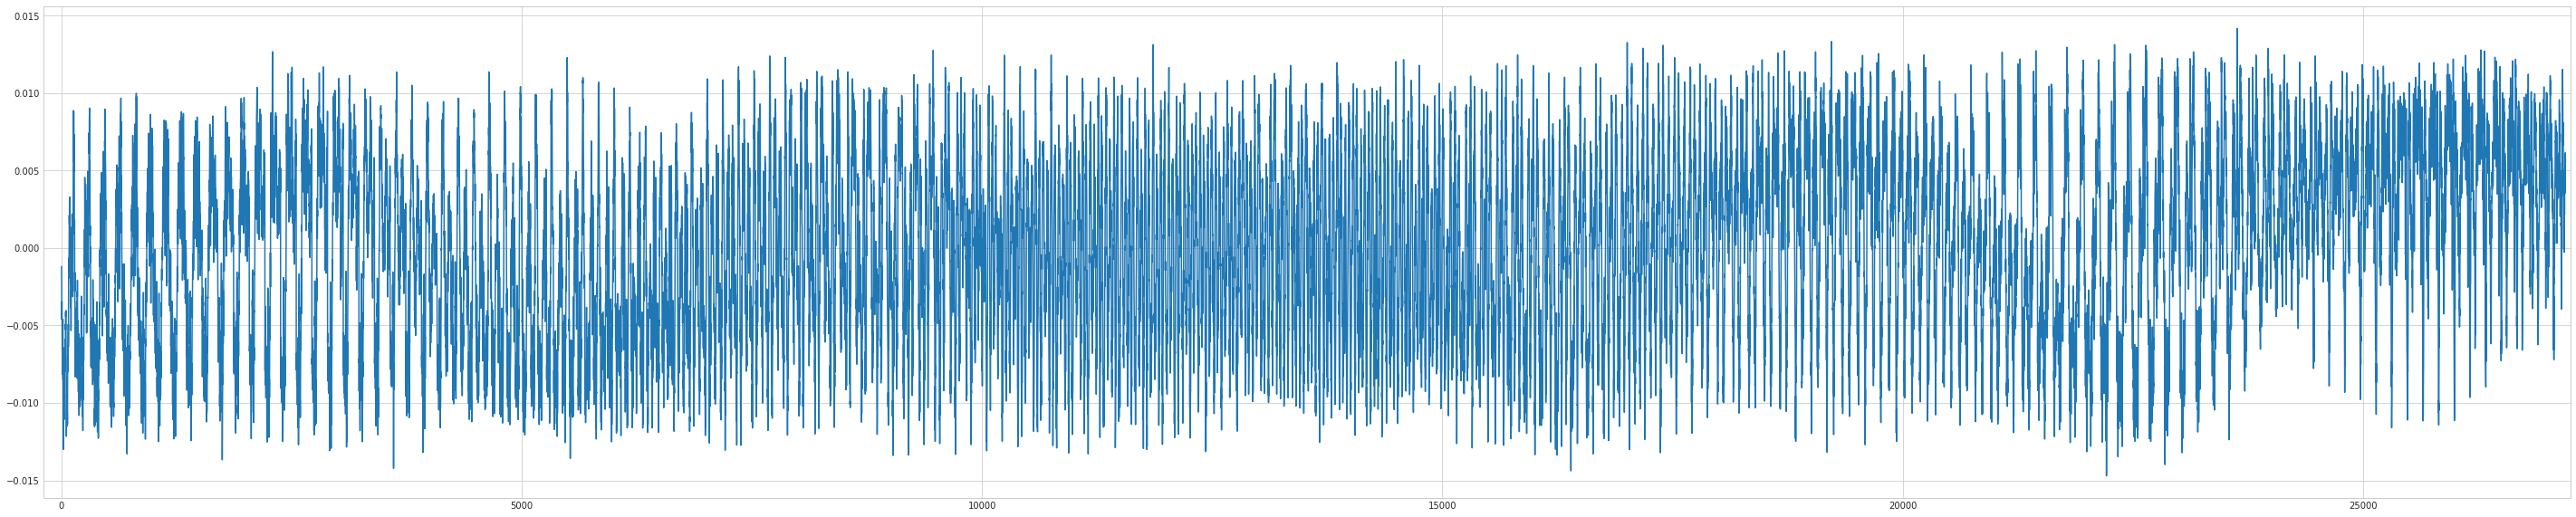

In [17]:
fig = plt.figure(figsize=(50, 10))
with plt.style.context('seaborn-whitegrid'):
    plt.plot(spatial_comp.transpose()[:, :1])
    plt.xlim(-200, 27250)
    # plt.savefig('reaction.png')
plt.show()


Какая красота
Кажется тут наложено много много синусоид друг на друга

In [20]:
spatial_images = spatial_comp.reshape(frames.shape)

In [30]:
n, m = 4, 5

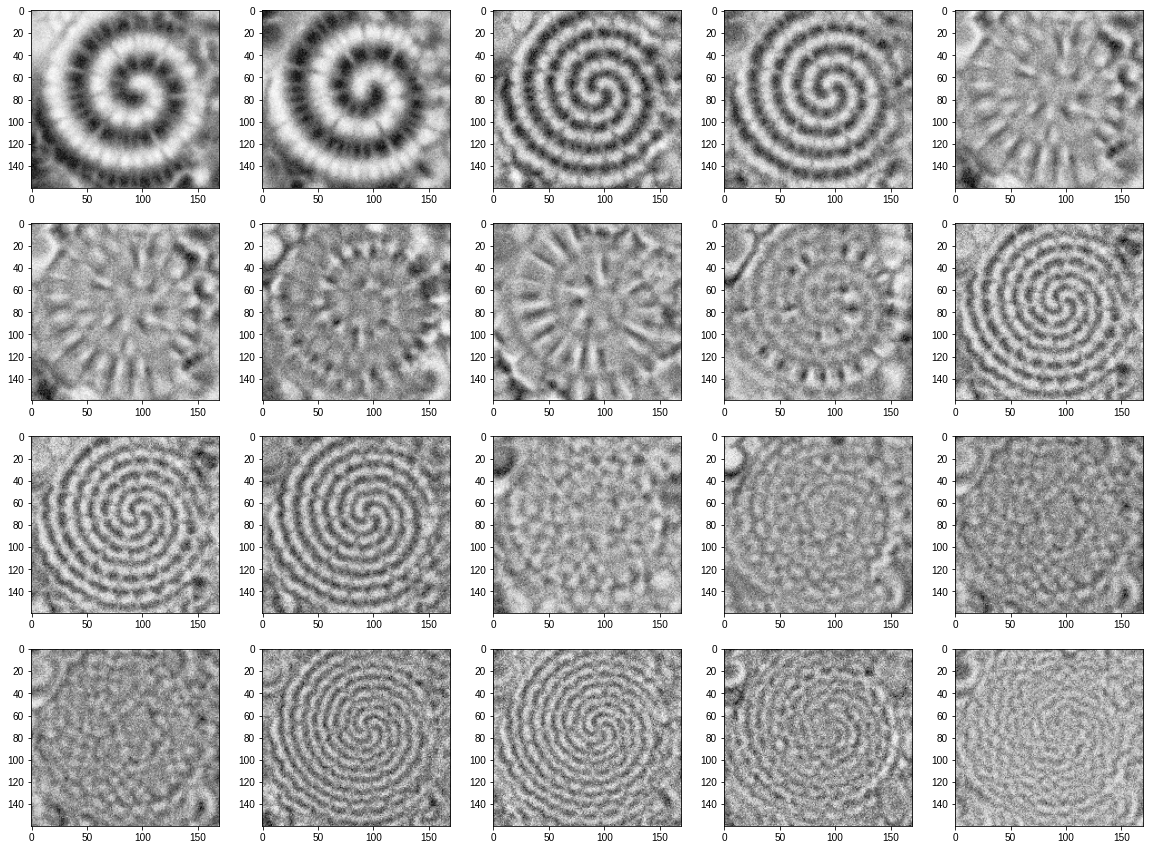

In [31]:
fig, axs = plt.subplots(n, m, figsize=(20, 15))
with plt.style.context('seaborn-whitegrid'):
    for i, ax in enumerate(axs):
        for j, axx in enumerate(ax):
            axx.imshow(spatial_images[(i*n+j)])
    plt.show()

Временные и пространственные компонент идут парами потому что соотвествуют одним и тем же собственным числам, а между собой пары поскольку собственные числа близки по значению

# Реконструкция


Количество компонент

In [22]:
def restore(k):
    transformed_frames = time_comp[:, :k]*s[:k]
    full_transformed_frames = transformed_frames.dot(spatial_comp[:k])
    return full_transformed_frames.reshape(frames.shape)

k = 3

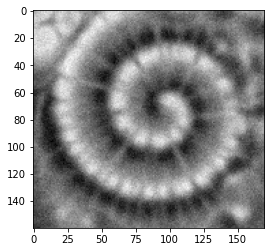

In [23]:
restored_frames = restore(3)
plt.imshow(restored_frames[0], cmap='gray')

k = 5

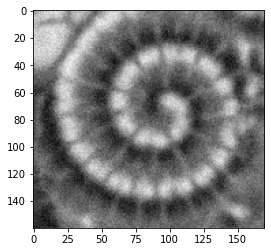

In [24]:
restored_frames = restore(5)
plt.imshow(restored_frames[0], cmap='gray')

k = 15

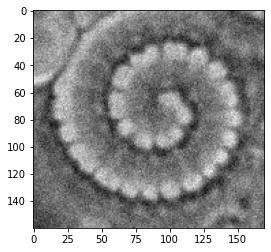

In [25]:
restored_frames = restore(15)
plt.imshow(restored_frames[0], cmap='gray')

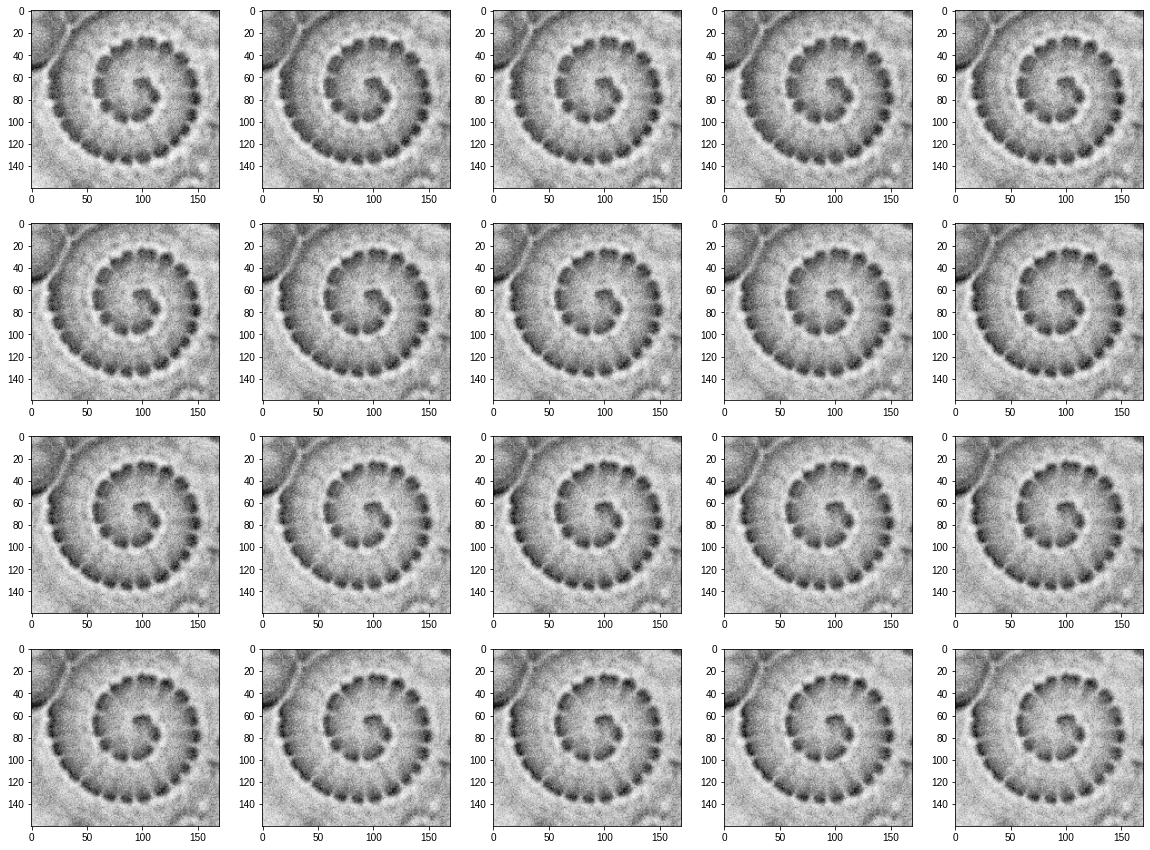

In [33]:
fig, axs = plt.subplots(n, m, figsize=(20, 15))
with plt.style.context('seaborn-whitegrid'):
    for i, ax in enumerate(axs):
        for j, axx in enumerate(ax):
            axx.imshow(restored_frames[(i*n+j+1)])
    plt.show()

Все кадры востановленного видео очень похожи. Решила вычесть первый кадр, чтобы посмотреть на разницу между ними

In [27]:
restored_frames_diff = np.subtract(restored_frames, restored_frames[0])

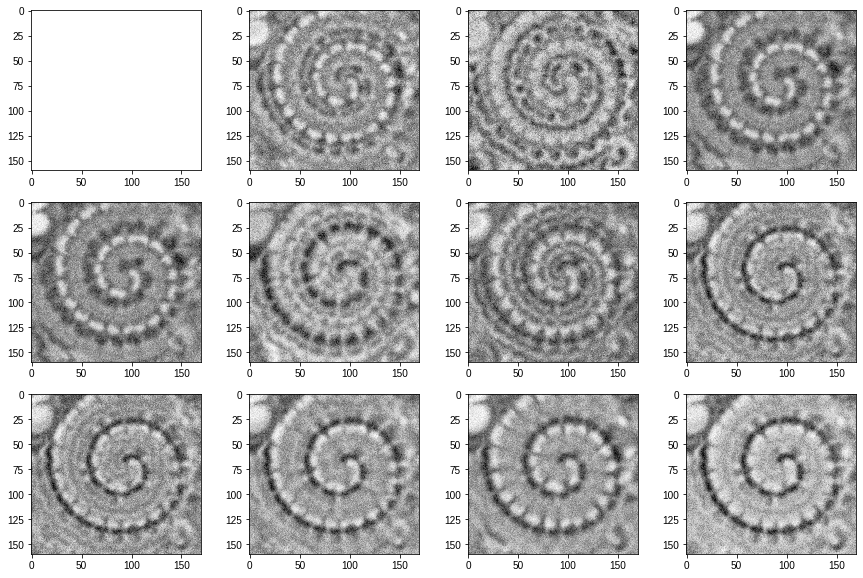

In [35]:
n, m = 3, 4
fig, axs = plt.subplots(n, m, figsize=(15, 10))
with plt.style.context('seaborn-whitegrid'):
    for i, ax in enumerate(axs):
        for j, axx in enumerate(ax):
            axx.imshow(restored_frames_diff[(i*n+j)])
    plt.show()

Используя svd уменьшаем ддисперсию значенй с минимальной потерей информации

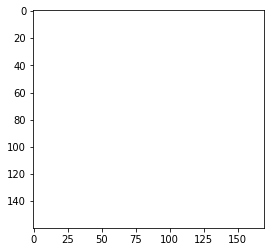

In [37]:
from celluloid import Camera
 
fig = plt.figure()
camera = Camera(fig)
 
for i in range(670):
    plt.imshow(restored_frames[i])
    camera.snap()
 
animation = camera.animate()
animation.save('celluloid_minimal.gif', writer = 'imagemagick')